In [41]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy
from metpy.plots import USCOUNTIES
import numpy as np
import xarray as xr
from siphon.catalog import TDSCatalog

In [42]:
def get_satellite(channel: str):
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/'
                        f'CONUS/Channel{channel}/current/catalog.xml')
    dataset = satcat.datasets[0]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

In [43]:
satellite_data = []

for channel in ['01', '02', '03', '13']:
    if channel == '02':
        # Downsample the imagery
        ds = get_satellite(channel)
        ds = ds[{'x': slice(None, None, 4), 'y': slice(None, None, 4)}]
        satellite_data.append(ds)
    elif channel == '01' or channel == '03':
        ds = get_satellite(channel)
        ds = ds[{'x': slice(None, None, 2), 'y': slice(None, None, 2)}]
        satellite_data.append(ds)
    elif channel == '13':
        ds = get_satellite(channel)
        satellite_data.append(ds)

In [44]:
# Channel 1 is 'Blue', Channel 2 is 'Red', Channel 3 is 'Green'
R = satellite_data[1].metpy.parse_cf('Sectorized_CMI').values
G = satellite_data[2].metpy.parse_cf('Sectorized_CMI').values
B = satellite_data[0].metpy.parse_cf('Sectorized_CMI').values
cleanIR = satellite_data[3].metpy.parse_cf('Sectorized_CMI').values

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

In [45]:
# Normalize the channel between a range.
#       cleanIR = (cleanIR-minimumValue)/(maximumValue-minimumValue)
cleanIR = (cleanIR-90) / (313-90)

# Apply range limits to make sure values are between 0 and 1
cleanIR = np.clip(cleanIR, 0, 1)

# Invert colors so that cold clouds are white
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright
# when we overlay it on the true color image.
cleanIR = cleanIR/1.4

# Yes, we still need 3 channels as RGB values. This will be a grey image.
RGB_cleanIR = np.dstack([cleanIR, cleanIR, cleanIR])

In [46]:
# Maximize the RGB values between the True Color Image and Clean IR image
RGB_ColorIR = np.dstack([np.maximum(R, cleanIR), np.maximum(G_true, cleanIR),
                         np.maximum(B, cleanIR)])

In [47]:
data = satellite_data[0].metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs
x = data['x']
y = data['y']

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(data['time'].values).split('.')[0])

In [48]:
def contrast_correction(color, contrast):
    """Modify the contrast of an RGB.
    See:
    https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        color    - an array representing the R, G, and/or B channel
        contrast - contrast correction level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.clip(COLOR, 0, 1)  # Force value limits 0 through 1.
    return COLOR


# Amount of contrast
contrast_amount = 105

# Apply contrast correction
RGB_contrast = contrast_correction(RGB, contrast_amount)

# Add in clean IR to the contrast-corrected True Color image
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:, :, 0], cleanIR),
                             np.maximum(RGB_contrast[:, :, 1], cleanIR),
                             np.maximum(RGB_contrast[:, :, 2], cleanIR)])

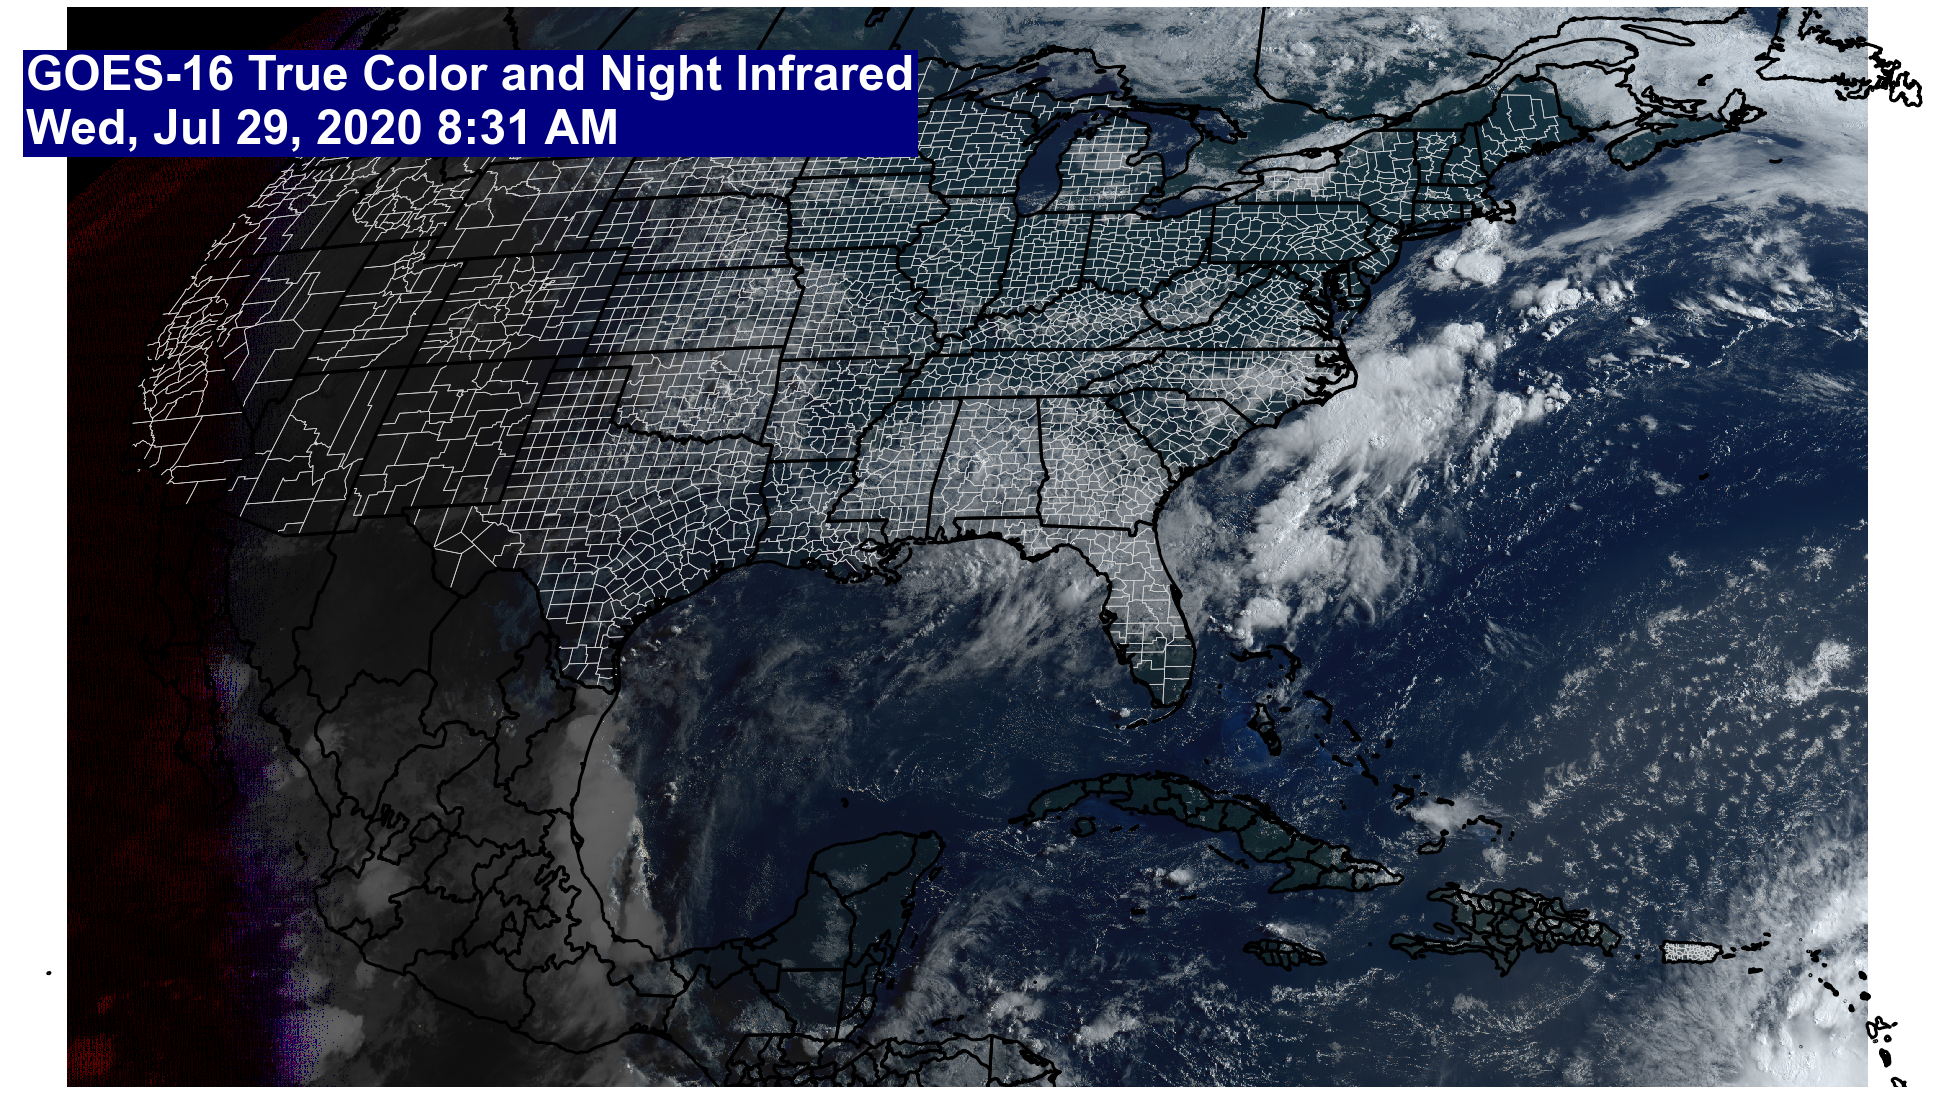

In [49]:
# Build the plot
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=proj)

#ax.set_extent([-110, -70, 20, 40])

ax.imshow(RGB_contrast_IR, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=proj, interpolation='none', cmap='Greys_r')

ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.0)
ax.set_adjustable('datalim')
ax.outline_patch.set_visible(False)

# Make the axis title
ax.set_title(f'GOES-16 True Color and Night Infrared\n{VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
plt.savefig(f'{graphics_dir}/vis_truecolor_night_ir.png', dpi=72)
plt.show()